## Data Collection

In [1]:
import numpy as np
import pandas as pd

#### Collecting OHLC data of Apple using the yfinance library

In [2]:
import yfinance as yf

symbol = 'AAPL'
start_date = '2015-01-01'
end_date = '2025-01-19'

stock_data = yf.download(symbol, start = start_date, end = end_date)

stock_data.head()

/var/folders/p9/wg3vtxhs1p1fv0539hxmwpyh0000gn/T/ipykernel_41579/837040907.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start = start_date, end = end_date)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2015-01-02,24.288582,24.757336,23.848707,24.746228,212818400
2015-01-05,23.604334,24.137514,23.417722,24.057537,257142000
2015-01-06,23.606558,23.866483,23.244438,23.668762,263188400
2015-01-07,23.937574,24.037545,23.704307,23.815387,160423600
2015-01-08,24.857311,24.915073,24.148625,24.266371,237458000


## Data Preproccessing and Cleaning

#### Adding indicators as extra features to improve performance using the talib library

In [4]:
import talib as ta

# Extract individual columns from multi-level DataFrame
close_prices = stock_data[('Close', 'AAPL')].astype(np.float64).to_numpy()
high_prices = stock_data[('High', 'AAPL')].astype(np.float64).to_numpy()
low_prices = stock_data[('Low', 'AAPL')].astype(np.float64).to_numpy()

# Adding MACD, RSI, SMA, EMA, and ADX indicators
macd, macd_signal, _ = ta.MACD(close_prices, fastperiod=12, slowperiod=26, signalperiod=9)
rsi = ta.RSI(close_prices, timeperiod=14)
sma_20 = ta.SMA(close_prices, timeperiod=20)
ema_20 = ta.EMA(close_prices, timeperiod=20)
adx = ta.ADX(high_prices, low_prices, close_prices, timeperiod=14)

stock_data['MACD'] = macd
stock_data['MACD_signal'] = macd_signal
stock_data['RSI'] = rsi
stock_data['SMA_20'] = sma_20
stock_data['EMA_20'] = ema_20
stock_data['ADX'] = adx

stock_data.dropna(inplace=True)

stock_data.tail()

Price,Close,High,Low,Open,Volume,MACD,MACD_signal,RSI,SMA_20,EMA_20,ADX
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,,
Date,,,,,,,,,,,
2025-01-13,233.835922,234.105277,229.167192,232.968021,49630700,-0.532619,2.104454,34.659200,248.002254,244.187795,30.663636
2025-01-14,232.718613,235.551775,231.910564,234.185076,39435300,-1.330972,1.417369,33.488070,247.270020,243.095492,30.551683
2025-01-15,237.297562,238.384950,233.865838,234.075339,39832000,-1.576022,0.818691,42.119726,246.758254,242.543308,29.690210
2025-01-16,227.710693,237.437230,227.481251,236.778830,71759100,-2.514817,0.151989,32.585005,245.621995,241.130678,29.858049
2025-01-17,229.426559,231.730998,227.930169,231.561409,68488300,-3.084803,-0.495369,35.403534,244.449823,240.016000,30.013900


In [5]:
df = stock_data

In [6]:
# Dropping unecessary columns which mostly won't contribute to the model
df = df.drop(['Open', 'High', 'Low'], axis=1)
df.head()

Price,Close,Volume,MACD,MACD_signal,RSI,SMA_20,EMA_20,ADX
Ticker,AAPL,AAPL,,,,,,
Date,,,,,,,,
2015-04-09,28.227343,129936000,-0.148894,-0.245072,50.095228,28.019466,28.120132,19.414589
2015-04-10,28.347771,160752000,-0.114788,-0.219015,51.520683,28.049018,28.141812,18.420055
2015-04-13,28.292013,145460400,-0.091206,-0.193453,50.797228,28.085373,28.156117,17.454390
2015-04-14,28.169348,102098400,-0.081476,-0.171058,49.161691,28.100428,28.157377,16.245538
2015-04-15,28.276402,115881600,-0.064384,-0.149723,50.654927,28.097529,28.168713,15.123033


## Splitting Data into Training and Testing Sets

In [7]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# First split the RAW data before scaling
train_raw, test_raw = train_test_split(df, test_size=0.2, shuffle=False)

# Initialize scaler
scaler = MinMaxScaler()

# Fit ONLY on training data
scaled_train = scaler.fit_transform(train_raw)
scaled_test = scaler.transform(test_raw)

# Convert back to DataFrames (important for sequence creation)
train_df = pd.DataFrame(scaled_train, columns=df.columns, index=train_raw.index)
test_df = pd.DataFrame(scaled_test, columns=df.columns, index=test_raw.index)

train_df.head()

Price,Close,Volume,MACD,MACD_signal,RSI,SMA_20,EMA_20,ADX
Ticker,AAPL,AAPL,,,,,,
Date,,,,,,,,
2015-04-09,0.047975,0.154393,0.458741,0.436485,0.417213,0.043299,0.041842,0.159000
2015-04-10,0.048737,0.204612,0.461203,0.438584,0.437675,0.043494,0.041987,0.142523
2015-04-13,0.048384,0.179692,0.462906,0.440642,0.427290,0.043734,0.042082,0.126525
2015-04-14,0.047607,0.109028,0.463608,0.442446,0.403813,0.043833,0.042091,0.106499
2015-04-15,0.048285,0.131489,0.464842,0.444164,0.425248,0.043814,0.042166,0.087902


In [8]:
sequence_length = 30

# Fucntion to create sequences
def create_sequences(data, sequence_length, stride=5):
    sequences = []
    for i in range(0, len(data) - sequence_length, stride):
        seq = data.iloc[i : i + sequence_length].values
        sequences.append(seq)
    return np.array(sequences)


train_sequences = create_sequences(train_df, sequence_length)
test_sequences = create_sequences(test_df, sequence_length)

# Assign directly to X_train/X_test
X_train = train_sequences
X_test = test_sequences

print("Training sequence shape:", X_train.shape)
print("Testing sequence shape:", X_test.shape)

Training sequence shape: (388, 30, 8)
Testing sequence shape: (93, 30, 8)


## Building LSTM Model

In [9]:
import torch
import torch.nn as nn

sequence_length = 30
num_features = X_train.shape[2]

class BiLSTMAutoencoder(nn.Module):
    def __init__(self, seq_len, num_feat):
        super().__init__()
        self.seq_len = seq_len
        self.num_feat = num_feat

        self.encoder_lstm1 = nn.LSTM(num_feat, 64, batch_first=True, bidirectional=True)
        self.encoder_ln1 = nn.LayerNorm(64*2)
        self.encoder_dropout1 = nn.Dropout(0.3)

        self.encoder_lstm2 = nn.LSTM(64*2, 32, batch_first=True, bidirectional=True)
        self.encoder_ln2 = nn.LayerNorm(32*2)

        self.decoder_lstm1 = nn.LSTM(32*2, 32, batch_first=True)
        self.decoder_ln1 = nn.LayerNorm(32)
        self.decoder_dropout1 = nn.Dropout(0.3)

        self.decoder_lstm2 = nn.LSTM(32, 64, batch_first=True)
        self.decoder_ln2 = nn.LayerNorm(64)

        self.output_layer = nn.Linear(64, num_feat)

    def forward(self, x):
        batch_size = x.size(0)
        x, _ = self.encoder_lstm1(x)
        x = self.encoder_ln1(x)
        x = self.encoder_dropout1(x)

        x, (h_n, _) = self.encoder_lstm2(x)
        h_forward = h_n[-2]
        h_backward = h_n[-1]
        h = torch.cat((h_forward, h_backward), dim=1)
        x = self.encoder_ln2(h)

        x = x.unsqueeze(1).repeat(1, self.seq_len, 1)

        x, _ = self.decoder_lstm1(x)
        x = self.decoder_ln1(x)
        x = self.decoder_dropout1(x)

        x, _ = self.decoder_lstm2(x)
        x = self.decoder_ln2(x)

        x = self.output_layer(x)
        return x

autoencoder = BiLSTMAutoencoder(sequence_length, num_features)
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS device is available and will be used.")
else:
    device = torch.device("cpu")
    print("MPS device not available, using CPU instead.")

print("Current device:", device)
autoencoder.to(device)
print(autoencoder)

MPS device is available and will be used.
Current device: mps
BiLSTMAutoencoder(
  (encoder_lstm1): LSTM(8, 64, batch_first=True, bidirectional=True)
  (encoder_ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (encoder_dropout1): Dropout(p=0.3, inplace=False)
  (encoder_lstm2): LSTM(128, 32, batch_first=True, bidirectional=True)
  (encoder_ln2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (decoder_lstm1): LSTM(64, 32, batch_first=True)
  (decoder_ln1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (decoder_dropout1): Dropout(p=0.3, inplace=False)
  (decoder_lstm2): LSTM(32, 64, batch_first=True)
  (decoder_ln2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (output_layer): Linear(in_features=64, out_features=8, bias=True)
)


In [10]:
import torch.optim as optim
import numpy as np

optimizer = optim.Adam(autoencoder.parameters(), lr=1e-4)
criterion = nn.MSELoss()

def add_noise(x, noise_std=0.01):
    noise = torch.randn_like(x) * noise_std
    return x + noise

## Model Training 

In [11]:
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import torch.optim as optim

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)  

train_dataset = TensorDataset(X_train_tensor)
val_dataset = TensorDataset(X_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

epochs = 50
patience = 5
best_val_loss = float('inf')
patience_counter = 0

optimizer = optim.Adam(autoencoder.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = nn.MSELoss()
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3)

train_losses_history = []
val_losses_history = []

for epoch in range(epochs):
    autoencoder.train()
    train_losses = []
    for (batch_x,) in train_loader:
        batch_x = batch_x.to(device)
        noisy_x = add_noise(batch_x)

        optimizer.zero_grad()
        outputs = autoencoder(noisy_x)
        loss = criterion(outputs, batch_x)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    avg_train_loss = np.mean(train_losses)

    autoencoder.eval()
    val_losses = []
    with torch.no_grad():
        for (batch_x,) in val_loader:
            batch_x = batch_x.to(device)
            outputs = autoencoder(batch_x)
            loss = criterion(outputs, batch_x)
            val_losses.append(loss.item())
    avg_val_loss = np.mean(val_losses)

    train_losses_history.append(avg_train_loss)
    val_losses_history.append(avg_val_loss)

    lr_scheduler.step(avg_val_loss)

    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")
    print(f"Learning rate: {optimizer.param_groups[0]['lr']:.6e}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        best_weights = autoencoder.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            autoencoder.load_state_dict(best_weights)
            break


Epoch 1, Train Loss: 0.631780, Val Loss: 0.986255
Learning rate: 1.000000e-04
Epoch 2, Train Loss: 0.388716, Val Loss: 0.615816
Learning rate: 1.000000e-04
Epoch 3, Train Loss: 0.258901, Val Loss: 0.400792
Learning rate: 1.000000e-04
Epoch 4, Train Loss: 0.184235, Val Loss: 0.270334
Learning rate: 1.000000e-04
Epoch 5, Train Loss: 0.142940, Val Loss: 0.203216
Learning rate: 1.000000e-04
Epoch 6, Train Loss: 0.112157, Val Loss: 0.172618
Learning rate: 1.000000e-04
Epoch 7, Train Loss: 0.098610, Val Loss: 0.155729
Learning rate: 1.000000e-04
Epoch 8, Train Loss: 0.089557, Val Loss: 0.143200
Learning rate: 1.000000e-04
Epoch 9, Train Loss: 0.078589, Val Loss: 0.134609
Learning rate: 1.000000e-04
Epoch 10, Train Loss: 0.074674, Val Loss: 0.127750
Learning rate: 1.000000e-04
Epoch 11, Train Loss: 0.066063, Val Loss: 0.117633
Learning rate: 1.000000e-04
Epoch 12, Train Loss: 0.064051, Val Loss: 0.108614
Learning rate: 1.000000e-04
Epoch 13, Train Loss: 0.056736, Val Loss: 0.098025
Learning r

## Data Visualization

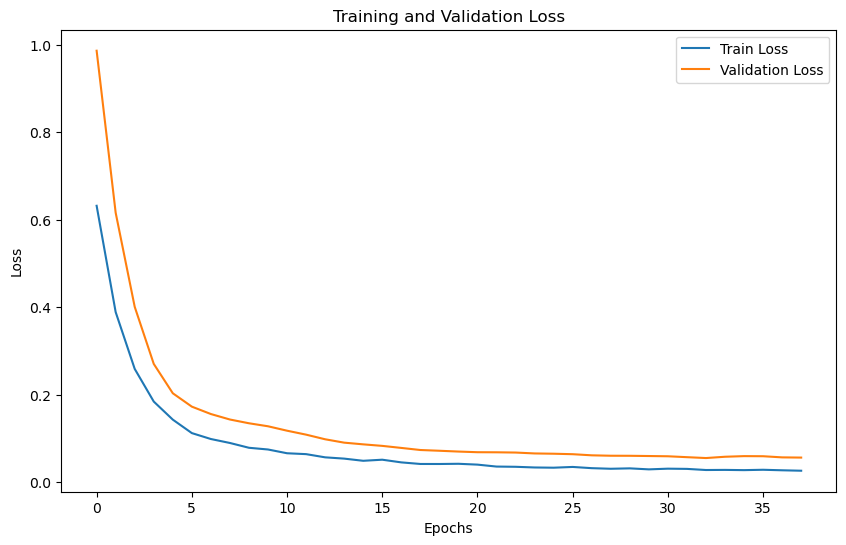

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_losses_history, label='Train Loss')
plt.plot(val_losses_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Threshold: 0.16974184322915006
Number of anomalies detected: 42
Sample anomaly dates: DatetimeIndex(['2023-04-10', '2023-04-11', '2023-04-12', '2023-04-13',
               '2023-04-14', '2023-04-17', '2023-04-18', '2023-04-19',
               '2023-04-20', '2023-05-12'],
              dtype='datetime64[ns]', name='Date', freq=None)


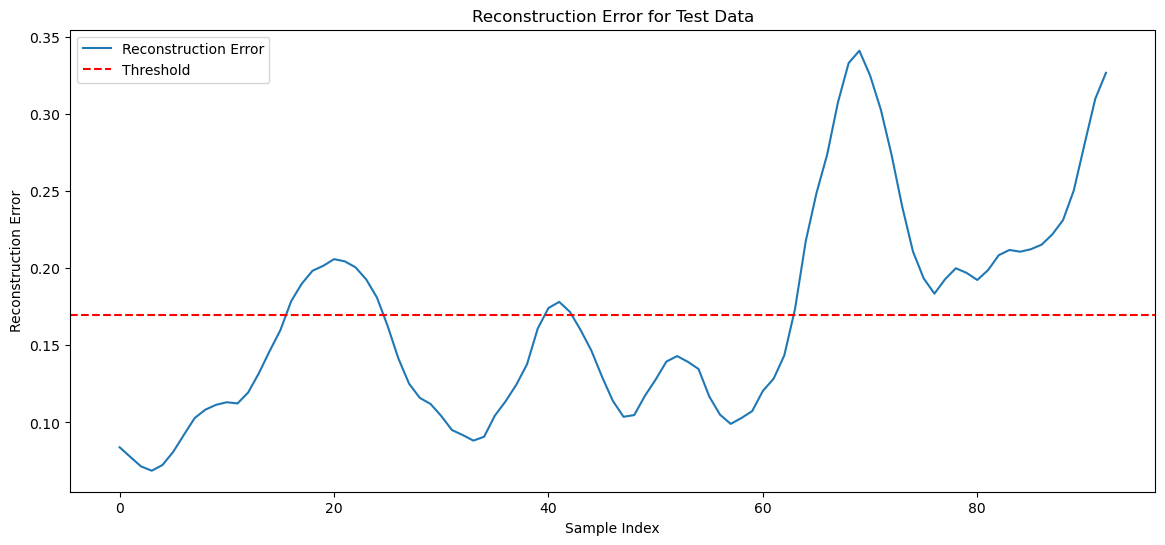

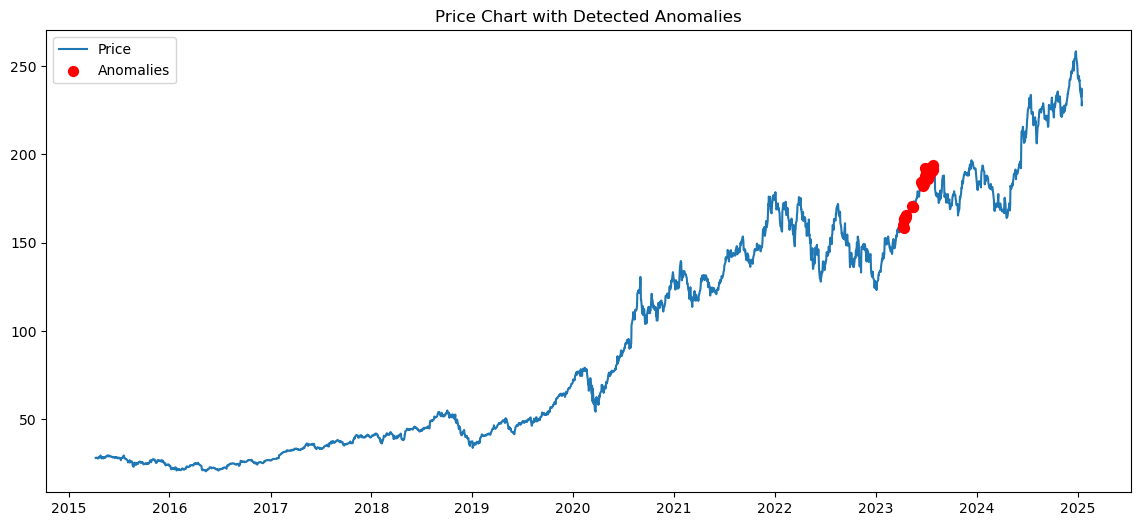

In [13]:
import torch

# Ensure model is in eval mode
autoencoder.eval()

with torch.no_grad():
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

    train_reconstructed = autoencoder(X_train_tensor).cpu().numpy()
    test_reconstructed = autoencoder(X_test_tensor).cpu().numpy()

# Calculate mean absolute reconstruction error per sequence
train_error = np.mean(np.abs(train_reconstructed - X_train), axis=(1, 2))
test_error = np.mean(np.abs(test_reconstructed - X_test), axis=(1, 2))

threshold = np.percentile(train_error, 99)
anomalies = test_error > threshold

print(f"Threshold: {threshold}")
print(f"Number of anomalies detected: {np.sum(anomalies)}")

anomaly_indices = np.where(anomalies)[0]
anomaly_dates = test_df.index[anomaly_indices + sequence_length]

print("Sample anomaly dates:", anomaly_dates[:10])

import matplotlib.pyplot as plt

# Plot reconstruction errors
plt.figure(figsize=(14, 6))
plt.plot(test_error, label='Reconstruction Error')
plt.axhline(threshold, color='red', linestyle='--', label='Threshold')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error for Test Data')
plt.legend()
plt.show()

# Plot price with anomalies
plt.figure(figsize=(14, 6))
plt.plot(stock_data['Close'], label='Price')
plt.scatter(anomaly_dates, stock_data.loc[anomaly_dates, 'Close'],
            color='red', s=50, zorder=5, label='Anomalies')
plt.title('Price Chart with Detected Anomalies')
plt.legend()
plt.show()
